In [1]:
%%html
<style>
div.optional {
    display: block;
    background-color: #d7e2ff;
    border-color: #d7e2ff;
    border-left: 5px solid #d7e2ff;
    padding: 0.5em;
}
div.advanced {
    display: block;
    background-color: #fff4d7;
    border-color: #fff4d7;
    border-left: 5px solid #fff4d7;
    padding: 0.5em;
}
</style>

# Modelling & Numerical Methods <a class="tocSkip">

## PDE Solvers: Finite Difference Methods 2 <a class="tocSkip">
    
### Homework Exercises - Solutions <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Homework" data-toc-modified-id="Homework-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homework</a></span><ul class="toc-item"><li><span><a href="#Homework---Upwind-vs-central-discretrisation" data-toc-modified-id="Homework---Upwind-vs-central-discretrisation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Homework - Upwind vs central discretrisation</a></span><ul class="toc-item"><li><span><a href="#Solution---Upwind-vs-central-discretrisation" data-toc-modified-id="Solution---Upwind-vs-central-discretrisation-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Solution - Upwind vs central discretrisation</a></span></li></ul></li><li><span><a href="#Homework---Larger-stencils-/-higher-orders-of-accuracy-[$\star$]-[from-Comp-Math]" data-toc-modified-id="Homework---Larger-stencils-/-higher-orders-of-accuracy-[$\star$]-[from-Comp-Math]-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Homework - Larger stencils / higher orders of accuracy [$\star$] [from Comp Math]</a></span><ul class="toc-item"><li><span><a href="#Solution---Larger-stencils-/-higher-orders-of-accuracy" data-toc-modified-id="Solution---Larger-stencils-/-higher-orders-of-accuracy-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Solution - Larger stencils / higher orders of accuracy</a></span></li></ul></li><li><span><a href="#Homework---Stability-study-for-advection-diffusion-using-FTCS" data-toc-modified-id="Homework---Stability-study-for-advection-diffusion-using-FTCS-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Homework - Stability study for advection-diffusion using FTCS</a></span></li><li><span><a href="#Homework---An-analytical-solution-to-advection-diffusion-[from-Comp-Math]" data-toc-modified-id="Homework---An-analytical-solution-to-advection-diffusion-[from-Comp-Math]-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Homework - An analytical solution to advection-diffusion [from Comp Math]</a></span><ul class="toc-item"><li><span><a href="#Solution---An-analytical-solution-to-advection-diffusion" data-toc-modified-id="Solution---An-analytical-solution-to-advection-diffusion-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Solution - An analytical solution to advection-diffusion</a></span></li></ul></li><li><span><a href="#Homework---Pure-advection---impact-of-time-step-[from-Comp-Math]" data-toc-modified-id="Homework---Pure-advection---impact-of-time-step-[from-Comp-Math]-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Homework - Pure advection - impact of time step [from Comp Math]</a></span><ul class="toc-item"><li><span><a href="#Solution---Pure-advection---impact-of-time-step" data-toc-modified-id="Solution---Pure-advection---impact-of-time-step-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Solution - Pure advection - impact of time step</a></span></li></ul></li></ul></li></ul></div>

In [2]:
%matplotlib inline
import numpy as np
import scipy.linalg as sl
# we'll start using sparse matrices here
import scipy.sparse as sp
# and linear algebra functions designed for sparse matrices
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation

# font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# Homework

## Homework - Upwind vs central discretrisation

Use our codes `BVP_AD_central` and `BVP_AD_upwind` to compute and plot error convergence for these two schemes for our test problem from the lecture with a Peclet number of 10.
    
Hence, establish that even though the upwind scheme is coupled with a second-order scheme for diffusion, it is the first-order contribution to the overall error which ultimately dominates and so the overall scheme is only first-order accurate.


### Solution - Upwind vs central discretrisation

In [3]:
def BVP_AD_central(L, U, kappa, CE, N):
    """ function to assemble and solve the AD BVP problem
    using central differences for both adv and diff
    """
    dx = L / N
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    r_diff = kappa / dx**2
    r_adv = 0.5 * U / dx
    for i in range(1, N + 1):
        A[i, i - 1] = r_diff + r_adv
        A[i, i] = -2 * r_diff
        A[i, i + 1] = r_diff - r_adv
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  # BC2
    # invert matrix
    C = np.linalg.solve(A, b)
    return x, C


def BVP_AD_upwind(L, U, kappa, CE, N):
    """ function to assemble and solve the AD BVP problem
    using central differences for both adv and diff
    """
    dx = L / N
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    r_diff = kappa / dx**2
    r_adv = U / dx
    for i in range(1, N + 1):
        A[i, i - 1] = r_diff + r_adv
        A[i, i] = -2 * r_diff - r_adv
        A[i, i + 1] = r_diff
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  # BC2
    # invert matrix
    C = np.linalg.solve(A, b)
    return x, C

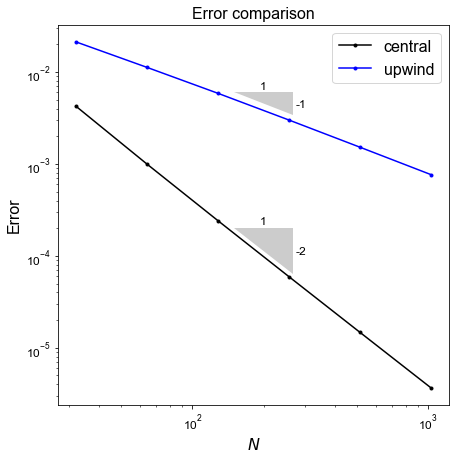

In [4]:
kappa = 0.005
L = 1
Pe = 10.
U = Pe * kappa / L
CE = 1

fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))

def exact_sol(x):
    return CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)

Ns = [32, 64, 128, 256, 512, 1024]
errors_central = np.zeros(len(Ns))
errors_upwind = np.zeros(len(Ns))

for i, N in enumerate(Ns):
    x, C = BVP_AD_central(L, U, kappa, CE, N)
    errors_central[i] = np.linalg.norm( C - exact_sol(x) ) / np.sqrt(len(x))
    x, C = BVP_AD_upwind(L, U, kappa, CE, N)
    errors_upwind[i] = np.linalg.norm( C - exact_sol(x) ) / np.sqrt(len(x))

ax1.loglog(Ns, errors_central, 'k.-', label='central')    
ax1.loglog(Ns, errors_upwind, 'b.-', label='upwind') 
ax1.set_xlabel('$N$', fontsize=16)
ax1.set_ylabel('Error', fontsize=16)
ax1.set_title('Error comparison', fontsize=16)
ax1.legend(loc='best', fontsize=16)
annotation.slope_marker((1.5e2, 6e-3), (-1, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((1.5e2, 2e-4), (-2, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)

<div class="optional">

## Homework - Larger stencils / higher orders of accuracy [$\star$] [from Comp Math]

We saw in the lecture first- and second-order approximations to the first derivative.

By making use of more points (expanding the stencil) it is possible to come up with approximations of arbitrary order.

Tables of coefficients, assuming a uniform mesh, can be found at:
<https://en.wikipedia.org/wiki/Finite_difference_coefficient>

Try expanding our example from the lecture where we computed the first derivative of $\sin(x)$ at the location $x=0.8$ and plotted the error as a function of $\Delta x$, with some other examples of finite difference stencils from the tables at that web page.

[NB. the part of the question above is quite simple - in the sample solution I demonstrate an implementation of the third order accurate scheme; the part of the question below is more complicated].

Note that in the section of that web page titled "Arbitrary stencil points" it also gives a matrix system which can be solved for the finite difference coefficients which provides an approximation of arbitrary order derivatices on an arbitrary stencil. 

For a more in-depth description and derivation take a look at: <http://web.media.mit.edu/~crtaylor/calculator.html>
(click on "How does it work?").

Write some code to construct and solve this matrix system, and hence extend the convergence plot we presented above for the first derivative of $\sin(x)$ and $x=0.8$ for orders 1-6.

</div>

### Solution - Larger stencils / higher orders of accuracy

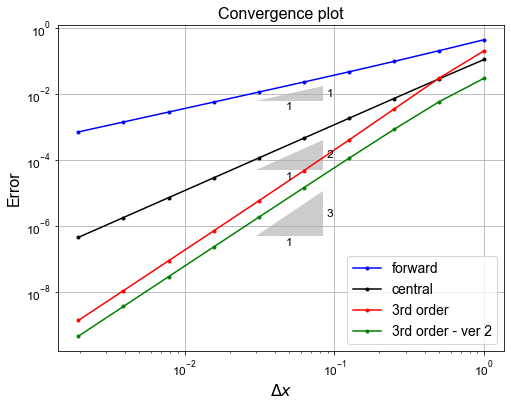

In [5]:
def forward_diff(f, x, dx):
    """ Function to evaluate the first-order forward finite difference
    approximation to the first derivative,
    of function $f$, at location $x$ and using a mesh size of $dx$.
    """
    fx = f(x)
    fxph = f(x + dx)
    return (fxph - fx) / dx

def central_diff(f, x, dx):
    """ Function to evaluate the second-order centred finite difference
    approximation to the first derivative,
    of function $f$, at location $x$ and using a mesh size of $dx$.
    """
    fxph = f(x + dx)
    fxnh = f(x - dx)
    return (fxph - fxnh) / (2 * dx)


def diff_3(f, x, dx):
    """ Function to evaluate at third-order accuracy the
    finite difference approximation to the first derivative,
    of function $f$, at location $x$ and using a mesh size of $dx$.
    """
    return (-11*f(x) + 18*f(x+dx) -9*f(x+2*dx) + 2*f(x+3*dx)) / (6 * dx)

def diff_3b(f, x, dx):
    """ Another function which evaluates at third-order accuracy the
    finite difference approximation to the first derivative,
    of function $f$, at location $x$ and using a mesh size of $dx$.
    """
    return (2*f(x+dx) + 3*f(x) - 6*f(x-dx) + f(x-2*dx)) / (6 * dx)

# for this example we know trivially what the exact solution should be
exact = np.cos(0.8)

# we're going to store all the values for plotting, initialise variable for these
fd_errors = []
cd_errors = []
d3_errors = []
d3_errorsb = []
dx_all = []
dx = 1.0  # an initial mesh spacing
for i in range(10):
    fd = forward_diff(np.sin, 0.8, dx)
    cd = central_diff(np.sin, 0.8, dx)
    d3 = diff_3(np.sin, 0.8, dx)
    d3b = diff_3b(np.sin, 0.8, dx)
    # store the h and the errors
    dx_all.append(dx)
    fd_errors.append(abs(fd - exact))
    cd_errors.append(abs(cd - exact))
    d3_errors.append(abs(d3 - exact))
    d3_errorsb.append(abs(d3b - exact))
    dx = dx / 2  # halve h for the next iteration


# set up figure
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)

ax1.loglog(dx_all, fd_errors, 'b.-', label='forward')
ax1.loglog(dx_all, cd_errors, 'k.-', label='central')
ax1.loglog(dx_all, d3_errors, 'r.-', label='3rd order')
ax1.loglog(dx_all, d3_errorsb, 'g.-', label='3rd order - ver 2')
ax1.set_xlabel('$\Delta x$', fontsize=16)
ax1.set_ylabel('Error', fontsize=16)
ax1.set_title('Convergence plot', fontsize=16)
ax1.grid(True)
ax1.legend(loc='best', fontsize=14)
annotation.slope_marker((3e-2, 6e-3), (1, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((3e-2, 5e-5), (2, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((3e-2, 5e-7), (3, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)

In [6]:
# functions to evaluate the finite difference coefficients and then
# use them to evaluate a numerical approximation to the derivative.

def calc_fd_coeffs(s, k):
    """ A function to compute finite difference coefficients 
    approximating an order k derivative on a stencil given by
    the array s.
    """
    n = len(s)
    A = np.zeros((n,n))
    b = np.zeros(n)
    for i in range(n):
        A[i,:] = s**i  
    b[k] = factorial(k)
    return np.linalg.solve(A,b)

def eval_fd_approx(f, x, s, fd_coeffs, dx):
    """ A function to evaluate the finite difference approximation to the
    derivative of f at location x using stencil s, finite diff coeffecients 
    from the function calc_fd_coeffs and with mesh spacing dx.
    """
    val = 0.
    for i in range(len(fd_coeffs)):
        val += fd_coeffs[i] * f(x + s[i]*dx)
    return val

fd_coeffs =  [-1.  1.]
fd_coeffs =  [-0.5  0.   0.5]
fd_coeffs =  [ 0.16666667 -1.          0.5         0.33333333]
fd_coeffs =  [ 8.33333333e-02 -6.66666667e-01 -2.37904934e-16  6.66666667e-01
 -8.33333333e-02]
fd_coeffs =  [-0.03333333  0.25       -1.          0.33333333  0.5        -0.05      ]
fd_coeffs =  [-1.66666667e-02  1.50000000e-01 -7.50000000e-01  5.89061811e-17
  7.50000000e-01 -1.50000000e-01  1.66666667e-02]


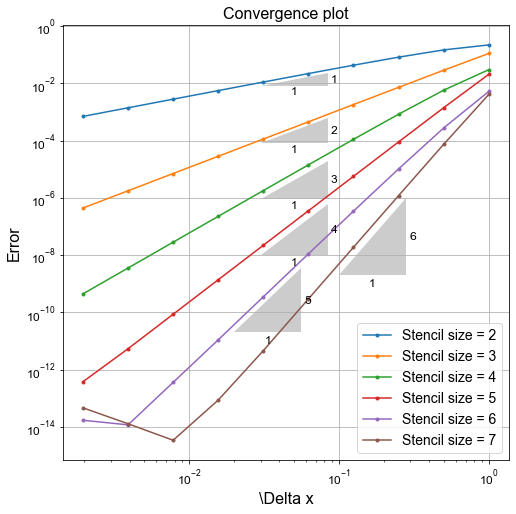

In [9]:
from math import factorial 

# for this example we know trivially what the exact solution should be
exact = np.cos(0.8)

# tuple of stencils to consider
ss = (np.array([-1,0]), 
      np.array([-1,0,1]), 
      np.array([-2,-1,0,1]), # this is the stencil implemented in function `diff_3b` above
      np.array([-2,-1,0,1,2]), 
      np.array([-3,-2,-1,0,1,2]), 
      np.array([-3,-2,-1,0,1,2,3]))

# dx values to use in the convergence plot
dxs = [2.**(-i) for i in range(10)]

# storage for the errors
errors = np.zeros((len(dxs), len(ss)))

   
for j, s in enumerate(ss):
    fd_coeffs = calc_fd_coeffs(s,1)
    print('fd_coeffs = ', fd_coeffs)
    for i, dx in enumerate(dxs):
        fd = eval_fd_approx(np.sin, 0.8, s, fd_coeffs, dx)
        # need to remember to divide through by mesh spacing to power of derivative order (here 1)
        fd = fd / dx
        errors[i,j] = abs(fd - exact)
        
# set up figure
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111)

for j in range(errors.shape[1]):
    ax1.loglog(dxs, errors[:,j], '.-', label='Stencil size = {0:1d}'.format(len(ss[j])))
    
ax1.set_xlabel('\Delta x', fontsize=16)
ax1.set_ylabel('Error', fontsize=16)
ax1.set_title('Convergence plot', fontsize=16)
ax1.grid(True)
ax1.legend(loc='best', fontsize=14)
annotation.slope_marker((3e-2, 8e-3), (1, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((3e-2, 8e-5), (2, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((3e-2, 9e-7), (3, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((3e-2, 1e-8), (4, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((2e-2, 2e-11), (5, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)
annotation.slope_marker((1e-1, 2e-9), (6, 1), ax=ax1,
                        size_frac=0.15, pad_frac=0.05)

## Homework - Stability study for advection-diffusion using FTCS

Play around with the example from the lecture in the section "Stability study for advection-diffusion". In particular play around with the physical and numerical parameters and investigate further the interplay between these, the locations of eigenvalues in the complex plane, and the observed stability of the numerical solver.

## Homework - An analytical solution to advection-diffusion [from Comp Math]

An exact solution to the advection-diffusion equation is given by


$$ c(x,t) = \frac{1}{\sqrt{4\pi \, \kappa \,t}}\exp\left  (-\frac{(x-Ut)^2}{4\kappa \, t}\right).$$


1. Note that this holds in an infinite domain - we can make use of it only as long as our numerical solution is far away from boundaries, or in a periodic domain as long as the solution behaviour does not start to encroach on itself.


2. The initial condition that this solution corresponds to is a [Dirac-delta function](https://en.wikipedia.org/wiki/Dirac_delta_function). We clearly can't represent this on our mesh as it has infinitesimal thickness - all sorts of problems would arise if we tried to. But what we can do is assume that our simulation starts at some $t>0$ and initialise our problem with the corresponding exact solution (which for $t>0$ is a Gaussian and for sufficiently large times can be represented on our mesh).


Write a function to evaluate this exact analytical solution and use it to initialise a simulation and plot a comparison between the exact and analytical solution at later times.

I suggest you use periodic boundary conditions (e.g. your starting point could be our function from the lecture `solve_adv_diff_Gaussian2`).

First try selecting some appropriate physical and numerical parameters such that you have a stable solution and avoid boundaries. Then try refining the spatial and temporal mesh to see if your solution gets closer to the exact solution.

### Solution - An analytical solution to advection-diffusion

In [10]:
def adv_diff_analytical_solution(U, kappa, x0, x, t):
    """ Analtical solution to advection-diffusion for an assumed 
    Dirac-delta initial condition at t=0.
    """
    return np.exp( -((x-x0) - U*t)**2 / (4.*kappa*t)) / np.sqrt(4. * np.pi * kappa * t)

CFL:  0.50000
Pe_c: 2.00000
r:    0.25000


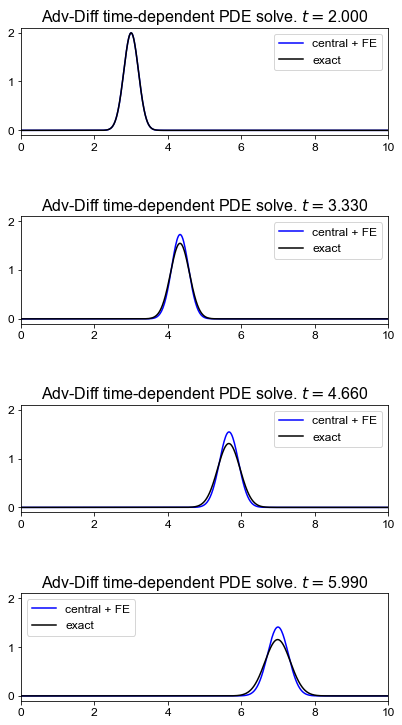

In [11]:
U = 1
kappa = 1./100.
N = 500
L = 10.
dx = L / N
dt = 0.01
t_start = 2.
t_end = t_start + 4.
x0 = 1.0

def adv_central_periodic(N):
    # advection - periodic
    Dx = 0.5*np.eye(N, k=1) - 0.5*np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dx[0, -1] = -0.5
    Dx[-1, 0] = 0.5
    return Dx

def diff_central_periodic(N):
    # diffusion - periodic
    Dxx = np.eye(N, k=1) - 2*np.eye(N) + np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dxx[0, -1] = 1
    Dxx[-1, 0] = 1
    return Dxx

def solve_adv_diff_Gaussian3(N, dt, t_start, t_end, U, kappa):
    """ Solve the advection-diffusion problem on a periodic domain
    with a hard coded Gaussian-shaped initial condition.
    
    Returns:
    C - the solution at all time levels.
    x - the spatial mesh.
    t - the time levels.
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)
       
    # create discretisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

    t = np.arange(t_start, t_end, dt)

    C = np.empty((len(x), len(t)))
    
    # define an initial condition
    C[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)
    
    I = np.eye(len(x))
    for n in range(len(t)-1):
        C[:,n+1] = (I + A * dt) @ C[:,n]
    return C, x, t

# and compute and print some key non-dimensional parameters
print('CFL:  {0:.5f}'.format(U*dt/dx))
print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('r:    {0:.5f}'.format(kappa*dt/(dx**2)))

# set up figure
fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

C, x, t = solve_adv_diff_Gaussian3(N, dt, t_start, t_end, U, kappa)
xf = np.linspace(0, L, 1000)
for i, n in enumerate(np.linspace(0, C.shape[1]-1, 4, dtype=int)):
    axs[i].plot(x, C[:,n], 'b-', label='central + FE')
    axs[i].plot(xf, adv_diff_analytical_solution(U, kappa, x0, xf, t[n]), 'k-', label='exact')
    axs[i].legend(loc='best')
    axs[i].set_xlim(0.0, 10.0)
    axs[i].set_ylim(-0.1, 2.1)
    axs[i].set_title('Adv-Diff time-dependent PDE solve. $t=${0:.3f}'.format(t[n]), fontsize=16)

CFL:  0.25000
Pe_c: 1.00000
r:    0.25000


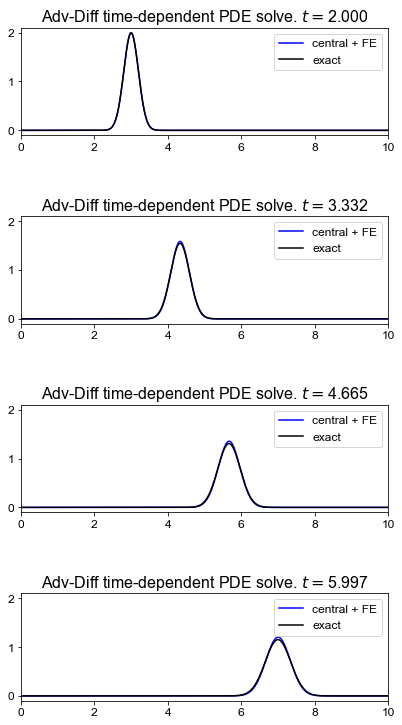

In [12]:
# try a smaller dx and dt

U = 1
kappa = 1./100.
N = 1000
L = 10.
dx = L / N
dt = 0.0025
t_start = 2.
t_end = t_start + 4.
x0 = 1.0

# and compute and print some key non-dimensional parameters
print('CFL:  {0:.5f}'.format(U*dt/dx))
print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('r:    {0:.5f}'.format(kappa*dt/(dx**2)))

# set up figure
fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

C, x, t = solve_adv_diff_Gaussian3(N, dt, t_start, t_end, U, kappa)
xf = np.linspace(0, L, 1000)
for i, n in enumerate(np.linspace(0, C.shape[1]-1, 4, dtype=int)):
    axs[i].plot(x, C[:,n], 'b-', label='central + FE')
    axs[i].plot(xf, adv_diff_analytical_solution(U, kappa, x0, xf, t[n]), 'k-', label='exact')
    axs[i].legend(loc='best')
    axs[i].set_xlim(0.0, 10.0)
    axs[i].set_ylim(-0.1, 2.1)
    axs[i].set_title('Adv-Diff time-dependent PDE solve. $t=${0:.3f}'.format(t[n]), fontsize=16)

## Homework - Pure advection - impact of time step [from Comp Math]

Write a solver for a pure advection problem in a periodic domain using forward Euler with upwind differences in space and with a Gaussian initial condition.

First test that it works/fails based on the CFL condition.

Then update the solver such that it selects the timestep automatically to satisfy a user-defined target Courant number, e.g. look to enforce a Courant number of 0.8.

### Solution - Pure advection - impact of time step

In [13]:
def adv_upwind_periodic(N):
    # advection - periodic
    Dx = np.eye(N, k=0) - np.eye(N, k=-1)
    # Add in the wrapped value due to periodicity
    Dx[0, -1] = -1
    return Dx

CFL:  0.20000
CFL:  0.40000
CFL:  0.80000
CFL:  1.60000


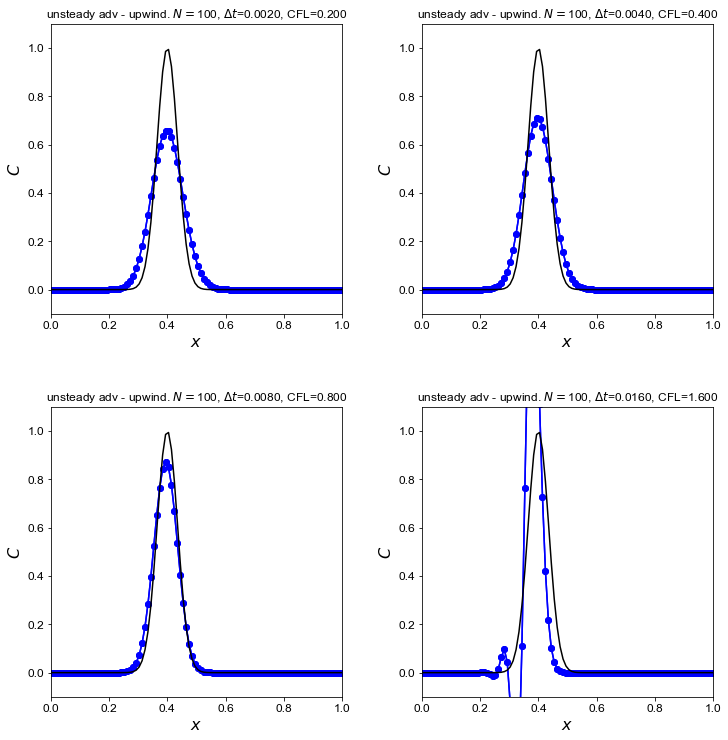

In [14]:
# physical parameters
L = 1
U = 1

def solve_adv_upwind(N, dt, t_start, t_end, U):
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)

    # create discrerisation matrix
    Dx = adv_upwind_periodic(N)
    A = -(U / dx) * Dx

    # time step using forward Euler - refer back to IVP lecture for details
    print('CFL:  {0:.5f}'.format(U*dt/dx))

    t = np.arange(t_start, t_end, dt)

    C = np.empty((len(x), 1))
    # define an initial condition
    C = np.exp(-((x-0.2)/0.05)**2)
    I = np.eye(len(x))
    for n in range(len(t)-1):
        C_prev = np.copy(C)
        C = (I + A * dt) @ C_prev
    return C, x


# set up figure with 4 subplots to plot 4 resolutions
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# reshape so that we can iterate below over axs[i] instead of ax[i,j]
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=6)

# let's compute solution and plot for 4 different time steps
N = 100
t_end = 0.2
for i, dt in enumerate((0.002, 0.004, 0.008, 0.016)):
    # call function to generate numerical solution
    C, x = solve_adv_upwind(N, dt, 0.0, t_end, U)
    axs[i].plot(x, C, 'bo-')
    axs[i].plot(x, C, 'bo-', x, np.exp(-(((x-U*t_end)-0.2)/0.05)**2), 'k')
    axs[i].set_xlabel('$x$', fontsize=16)
    axs[i].set_ylabel('$C$', fontsize=16)
    axs[i].set_title(
        'unsteady adv - upwind. $N=${0:3d}, $\Delta t$={1:.4f}, CFL={2:.3f}'.format(N, dt, U*dt/(L / N)), fontsize=12)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(-0.1, 1.1)

#### Comments

- So we see the scheme go unstable as we break the CFL<1 criterion we established for forward Euler.


- We can of course fix this by allowing the solver to choose its own time step.

#### Pure advection - variable time step

Let's see what happens if we refine the mesh but ask the solver to select a time step to maintain stability


Computing solution for N =  50
Computing solution for N =  100
Computing solution for N =  200
Computing solution for N =  400


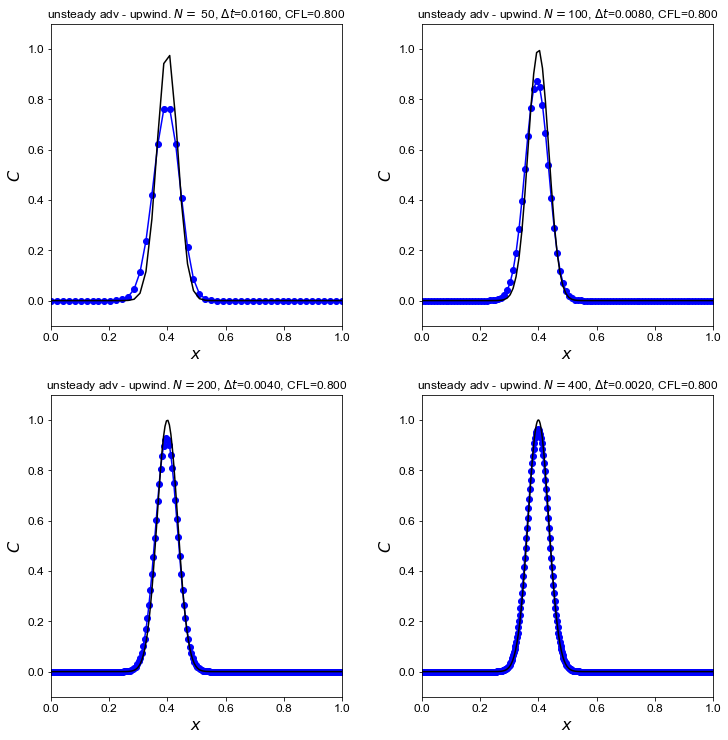

In [15]:
# physical parameters
L = 1
U = 1

tend = 0.2

def solve_adv_upwind_CFL(N, CFL, t_start, t_end, U):
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)

    # create discrerisation matrix
    Dx = adv_upwind_periodic(N)
    A = -(U / dx) * Dx

    dt = CFL*dx/U
    
    t = np.arange(0, tend, dt)

    C = np.empty((len(x), 1))
    # define an initial condition
    C = np.exp(-((x-0.2)/0.05)**2)
    I = np.eye(len(x))
    for n in range(len(t)-1):
        C_prev = np.copy(C)
        C = (I + A * dt) @ C_prev
    return C, x, dt


# set up figure with 4 subplots to plot 4 resolutions
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# reshape so that we can iterate below over axs[i] instead of ax[i,j]
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=4)

t_end = 0.2
# let's compute solution and plot for 4 different mesh resolutions
for (i, N) in enumerate((50, 100, 200, 400)):
    print('Computing solution for N = ',N)
    # call function to generate numerical solution
    C, x, dt = solve_adv_upwind_CFL(N, 0.8, 0.0, t_end, U)
    axs[i].plot(x, C, 'bo-', x, np.exp(-(((x-U*t_end)-0.2)/0.05)**2), 'k')
    axs[i].set_xlabel('$x$', fontsize=16)
    axs[i].set_ylabel('$C$', fontsize=16)
    axs[i].set_title(
        'unsteady adv - upwind. $N=${0:3d}, $\Delta t$={1:.4f}, CFL={2:.3f}'.format(N, dt, U*dt/(L / N)), fontsize=12)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(-0.1, 1.1)


#### Comments

- We see that by refining both the mesh size and the time step together we both retain stability as well as (appear to - we should check this rigorously of course) converge to the true solution.